In [4]:
import numpy as np ; import re
from matplotlib import pyplot;
import matplotlib.pyplot as plt ; import matplotlib.image as mpimg ;
from matplotlib.pyplot import imshow, plot, figure
import PIL; from PIL import *; from PIL import Image, ImageFilter
import tesserocr; from tesserocr import PyTessBaseAPI, PSM
import cv2;
%matplotlib inline

Collection of images for testing.

In [5]:
images = ['../data-test/petrol.jpg',
          '../data-test/petrol-bigger.jpg',
          '../data-test/petrol-bigger-2.jpg',
          '../data-test/omv.jpg',
          '../data-test/omv-small.jpg',
         '../data-test/omv-three.jpg']

Listing all images that will be processed.

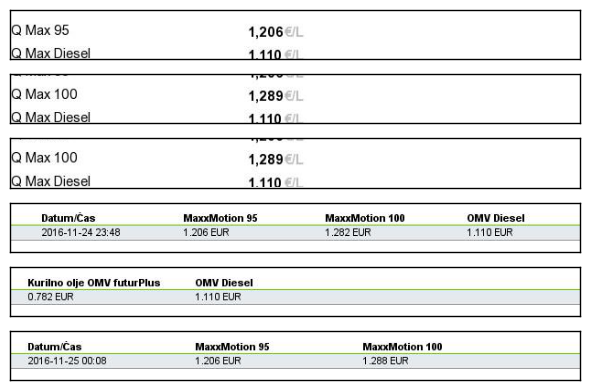

In [6]:
f, rows = plt.subplots(len(images), sharex=True, dpi=100, frameon=False, tight_layout
=False, linewidth=0) # , sharey=True)
for index, image in enumerate(images):
    rows[index].grid(False)
    rows[index].axis('on')
    rows[index].set_xticks([])
    rows[index].set_yticks([])
    rows[index].imshow(Image.open(image), cmap='gray')

f.tight_layout()
f ;

In [7]:
img_a = cv2.imread(images[5], cv2.IMREAD_ANYDEPTH + cv2.IMREAD_GRAYSCALE)
img_a.shape

(30, 624)

In [8]:
img_a = cv2.imread(images[0], cv2.IMREAD_ANYDEPTH + cv2.IMREAD_GRAYSCALE)
img_a.shape

(70, 324)

`read_prepare` preprocesses image for OCR with OpenCV3
- [cv2.resize](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=resize#cv2.resize)
- [cv2.imread](http://docs.opencv.org/3.0-beta/modules/imgcodecs/doc/reading_and_writing_images.html?highlight=imread#cv2.imread)

In [9]:
def otsu(path, blur_n=1):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.GaussianBlur(img,(blur_n,blur_n),0)

    hist = cv2.calcHist([blur],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()
    
    bins = np.arange(256)
   
    fn_min = np.inf
    thresh = -1
   
    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        b1,b2 = np.hsplit(bins,[i]) # weights
       
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    # find otsu's threshold value with OpenCV function
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return otsu

In [1]:
def read_prepare_explore(path, min_f=2.40, max_f=2.30):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    original_width = image.shape[1]
    if original_width < 400:
        basewidth = int(original_width * min_f) # 1500
    else:
        basewidth = int(original_width * max_f) # 1500

    wpercent = float(basewidth) / float(image.shape[1])
    hsize = int((float(image.shape[0]) * float(wpercent)))
    
    # images_resized = cv2.resize(image, (basewidth, hsize), interpolation=cv2.INTER_CUBIC)
    #ocr_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #ocr_otsu = cv2.threshold(ocr_gray, 0, 255, cv2.THRESH_OTSU)[1]

    image_resized = cv2.resize(image, (basewidth, hsize), interpolation=cv2.INTER_NEAREST)
    _, image_resized = cv2.threshold(image_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # blur = cv2.GaussianBlur(image,(2,2),0)
    # _, image_resized = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return Image.fromarray(image_resized)


In [ ]:
def read_prepare_explore(path, min_f=2.40, max_f=2.30):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    original_width = image.shape[1]
    if original_width < 400:
        basewidth = int(original_width * min_f)
    else:
        basewidth = int(original_width * max_f)

    wpercent = float(basewidth) / float(image.shape[1])
    hsize = int((float(image.shape[0]) * float(wpercent)))

    image_resized = cv2.resize(image, (basewidth, hsize), interpolation=cv2.INTER_NEAREST)
    _, image_resized = cv2.threshold(image_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return Image.fromarray(image_resized)

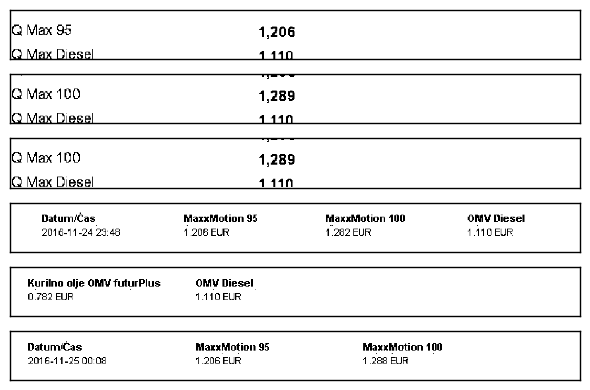

In [12]:
f, rows = plt.subplots(len(images), sharex=True, dpi=100, frameon=False, tight_layout
=False, linewidth=0) # , sharey=True)
for index, image in enumerate(images):
    rows[index].grid(False)
    rows[index].axis('on')
    rows[index].set_xticks([])
    rows[index].set_yticks([])
    rows[index].imshow(read_prepare(image), cmap='gray')

f.tight_layout()
f ;

In [13]:
def ocr_on(image, debug=False):
    api = PyTessBaseAPI(lang="slv") # , psm=PSM.SINGLE_BLOCK)
    api.SetImage(image)
    api.SetVariable("tessedit_char_whitelist", "čČabcdefghijklmnopqrstuvwxyz" \
                    "ABCDEFGHIJKLMNOPQRSTUVWXYZ0987654321-.,:/")
    api.SetVariable("classify_enable_learning", "0")
    api.SetVariable("classify_enable_adaptive_matcher", "0")
    api.SetVariable("load_system_dawg", "0")
    api.SetVariable("load_freq_dawg", "0")
    
    if debug:
        confidences = api.AllWordConfidences()
        words = api.AllWords()
        return [confidences, words, api.GetUTF8Text()]
        
    return api.GetUTF8Text()

In [14]:
for f in range(22,27,1):
    print("min_f = %.2f\n------" % (f/10))
    print(ocr_on(read_prepare(images[1], min_f=f/10)))

min_f = 2.20
------
Q Max 95 1,206
Q Max 100 1,289
Q Max Diesel 1,110
Kurilno olje EL 0,733


min_f = 2.30
------
Q Max 95 1,206
Q Max100 1,289
Q Max Diesel 1,110
Kurilno olje EL 0,783


min_f = 2.40
------
G Max 95 1,206
Q Max 100 1,289
Q Max Diesel 1,110
Kurilno olje EL 0383


min_f = 2.50
------
Q Max 95 1,206
Q Max 100 1,289
Q Max Diesel 1,110
Kurilno olje EL 0,783


min_f = 2.60
------
Q Max 95 1,206
Q Max1DD 1,239
Q Max Diesel 1,110
Kurilno Dlje EL 0,733




In [331]:
for f in range(18,26,1):
    print("max_f = %.2f\n------" % (f/10))
    print(ocr_on(read_prepare(images[3], max_f=f/10)))

max_f = 1.80
------
Daiumitas MaxxMuliun 95 MaxxMuliun 100 OMV Diesel
2016-11-24 23:48 1.206 EUR 1.282 EUR 1 .11U EUP.


max_f = 1.90
------
Datume-as- Maxmeiun 95 MaxxMotion 100 OMV Diesel
2016711724 23:48 1.206 EUR 1.282 EUR 1.110 EUR


max_f = 2.00
------
Datumitas- MaxxMution 95 MaxxMution 1llll OMV Diesel
2016-11-24 23:48 1.206 EUR 1.282 EUR 1 .110 EUR


max_f = 2.10
------
Datumu-Cas. MauMution 95 ManMution 100 OMV Diesel
2016-11-24 23:48 1.206 EUR 1.282 EUR 1 .110 EUR


max_f = 2.20
------
DatumIČas- Maxxnflotion 96 Maunnotion 1lJll OMV Diesel
2016-11-24 23:48 1 .206 EUR 1.282 EUR 1 .110 EUR


max_f = 2.30
------
DatumIČas. Maxxnflution 95 MaxxMotion 1llll OMV Diesel
2016-11-24 23:48 1 206 EUR 1.282 EUR 1 .110 EUR


max_f = 2.40
------
DatumICas. MaxxMutinn 95 ManMutinn 1llll OMV Diesel
2016-11-24 23:48 1.206 EUR 1.282 EUR 1 .110 EUR


max_f = 2.50
------
Datumi-las. MauMulinn 95 Maululotion 1llll OMV Diesel
2016-11-24 23:48 1.206 EUR 1.282 EUR 1 .110 EUR.




In [15]:
for image in images:
    print("image = %s" % image)
    print(ocr_on(read_prepare(image)))

image = ../data-test/petrol.jpg
Cz Max 95 1,206
Q Max Diesel 1,110


image = ../data-test/petrol-bigger.jpg
G Max 95 1,206
Q Max 100 1,289
Q Max Diesel 1,110
Kurilno olje EL 0383


image = ../data-test/petrol-bigger-2.jpg
G Max 95 1,206
Q Max 100 1,289
Q Max Diesel 1,110
Q Max LPG 0,615


image = ../data-test/omv.jpg
DatumIČas. Maxxnflution 95 MaxxMotion 1llll OMV Diesel
2016-11-24 23:48 1 206 EUR 1.282 EUR 1 .110 EUR


image = ../data-test/omv-small.jpg
Kurilno olje OMV fLIlurPIus ONIH Diesel-
0782 EUR 1 .110 EUR


image = ../data-test/omv-three.jpg
DatumrČas MaxxMution 95 quxMution 1Dll
2016-11-25 00:08 1 206 EUR 1 288 EUR




In [17]:
process = ocr_on(read_prepare(images[3]),debug=True)

In [18]:
confidences, words, text = process
' '.join(word for confidence, word in zip(confidences, words))

'DatumIČas. Maxxnflution 95 MaxxMotion 1llll OMV Diesel 2016-11-24 23:48 1 206 EUR 1.282 EUR 1 .110 EUR'

In [78]:
def text_fixer(ocr_process, show_original=False):
    confidences, words, text = ocr_process
    out_text = ' '.join(word for confidence, word in zip(confidences, words))
    return out_text.strip()

def prices_from_text(text):
    p = re.compile(r"(\d(\,?\s?|\s?\.?\,?)\d{3}\s+?)")
    return p.findall(text)

def number_fixer(text):
    return re.sub(r"(\s+)\.\,", '.', text)

prices = prices_from_text(text_fixer(ocr_on(read_prepare(images[3]), debug=True)))
ppr = [price[0].strip() for price in prices]
ppr

['1 206', '1.282', '1 .110']